In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import utils

In [2]:
IMG_SIZE = 180

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
class_names = metadata.features['label'].names

image.shape = (333, 500, 3)


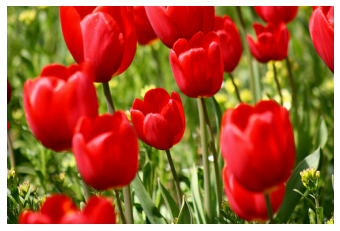

In [4]:
image, label = next(iter(train_ds))
image /= 255
print(f"image.shape = {image.shape}")
utils.plot_image(image)

## Resize and crop

resized.shape = (180, 180, 3)


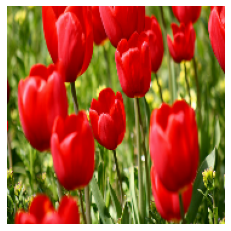

In [5]:
resized = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
print(f"resized.shape = {resized.shape}")
utils.plot_image(resized)

resized.shape = (120, 180, 3)


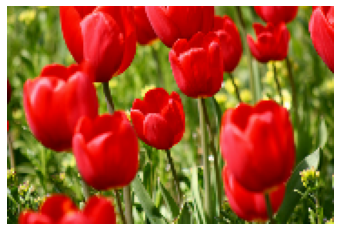

In [6]:
resized = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], preserve_aspect_ratio=True)
print(f"resized.shape = {resized.shape}")
utils.plot_image(resized)

resized.shape = (180, 180, 3)


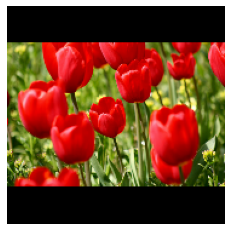

In [7]:
resized = tf.image.resize_with_pad(image, target_height=IMG_SIZE, target_width=IMG_SIZE)
print(f"resized.shape = {resized.shape}")
utils.plot_image(resized)

resized.shape = (180, 180, 3)


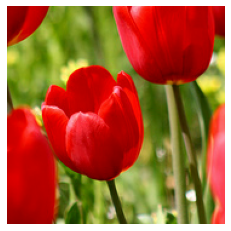

In [8]:
resized = tf.image.resize_with_crop_or_pad(image, target_height=IMG_SIZE, target_width=IMG_SIZE)
print(f"resized.shape = {resized.shape}")
utils.plot_image(resized)

## Center crop

cropped.shape = (333, 500, 3)


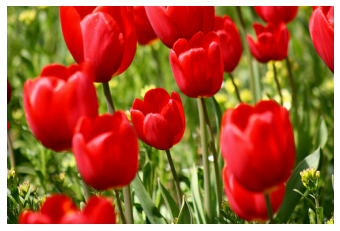

In [9]:
cropped = tf.image.central_crop(image, central_fraction=1)
print(f"cropped.shape = {cropped.shape}")
utils.plot_image(cropped)

cropped.shape = (167, 250, 3)


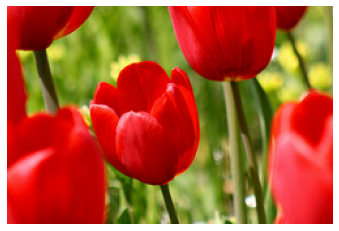

In [10]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
print(f"cropped.shape = {cropped.shape}")
utils.plot_image(cropped)

In [11]:
def center_crop(image):
    # image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    if len(shape) == 4:
        height, width = shape[1], shape[2]
    else:
        height, width = shape[0], shape[1]
    size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(image, (height - size) // 2, (width - size) // 2, size, size)
    return image

cropped.shape = (333, 333, 3)


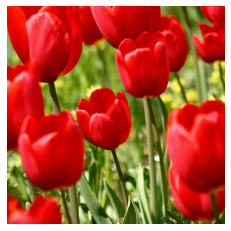

In [12]:
cropped = center_crop(image)
print(f"cropped.shape = {cropped.shape}")
utils.plot_image(cropped)

In [13]:
def center_crop_and_resize(image):
    # image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    height, width = tf.cast(shape[1], tf.float32), tf.cast(shape[2], tf.float32)
    size = tf.minimum(height, width)
    crop_box = (
        (height - size) / 2 / height, 
        (width - size) / 2 / width,
        (height + size) / 2 / height, 
        (width + size) / 2 / width,
    )
    image = tf.image.crop_and_resize(image, [crop_box], [0], (IMG_SIZE, IMG_SIZE))
    return image

cropped.shape = (1, 180, 180, 3)


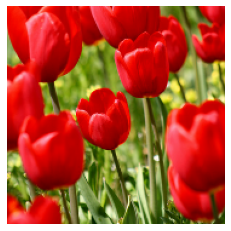

In [14]:
cropped = center_crop_and_resize(tf.expand_dims(image, 0))
print(f"cropped.shape = {cropped.shape}")
utils.plot_image(cropped)

## Augmentation

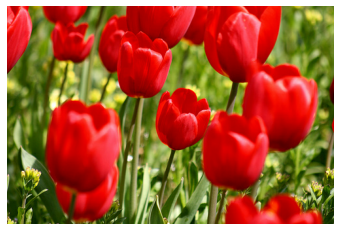

In [15]:
flipped = tf.image.flip_left_right(image)
utils.plot_image(flipped)

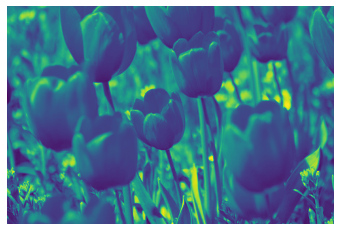

In [16]:
grayscaled = tf.image.rgb_to_grayscale(image)
utils.plot_image(grayscaled)

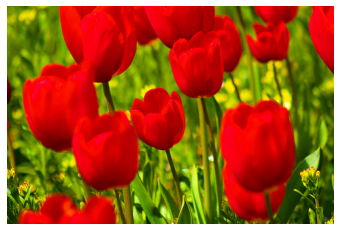

In [17]:
saturated = tf.image.adjust_saturation(image, 3)
utils.plot_image(saturated)

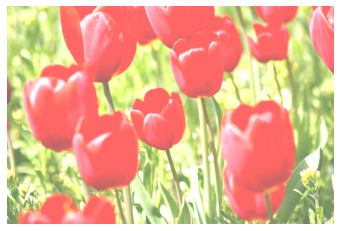

In [18]:
bright = tf.image.adjust_brightness(image, 0.4)
utils.plot_image(bright)

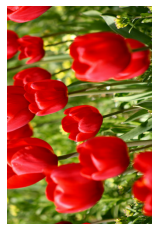

In [19]:
rotated = tf.image.rot90(image)
utils.plot_image(rotated)

## Use with dataset

In [20]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [21]:
def augment(image, label):
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

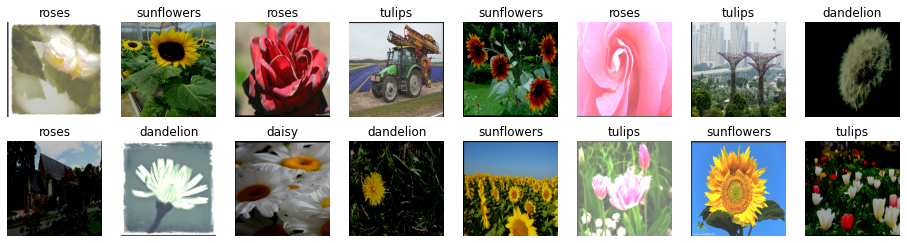

In [23]:
batch_x, batch_y = next(iter(train_ds))
utils.plot_images(batch_x[:16], batch_y[:16], class_names)